Translation Invariance Test And Permutation/Occlusion Test


In [7]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.datasets import STL10
from torchvision.models import resnet50
from timm import create_model  
import numpy as np
from PIL import Image


In [8]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225])
])

test_dataset = STL10(root='./data', split='test', download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


100%|██████████| 2.64G/2.64G [02:00<00:00, 21.9MB/s] 


In [9]:
import torch
import timm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_classes = 10  

import torchvision.models as models
resnet = models.resnet50(num_classes=num_classes)
resnet.load_state_dict(torch.load('/kaggle/input/modelss/resnet_stl10.pth', map_location=device))
resnet.to(device)
resnet.eval()
print("ResNet loaded!")

vit = timm.create_model("vit_small_patch16_224", pretrained=False, num_classes=num_classes)
vit.load_state_dict(torch.load('/kaggle/input/modelss/vit_stl10.pth', map_location=device))
vit.to(device)
vit.eval()
print("ViT (timm) loaded!")


ResNet loaded!
ViT (timm) loaded!


In [18]:
def translate_image(img, dx=5, dy=5):
    return T.functional.affine(img, angle=0, translate=(dx, dy), scale=1.0, shear=0)


def evaluate_translation(model, loader, dx=5, dy=5):
    correct, total = 0, 0
    for imgs, labels in loader:
        imgs = torch.stack([translate_image(img, dx, dy) for img in imgs]).to(device)
        labels = labels.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return correct / total


In [19]:
def patch_shuffle(img, patch_size=32):
    C, H, W = img.shape
    patches = img.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
    patches = patches.contiguous().view(C, -1, patch_size, patch_size)
    idx = torch.randperm(patches.size(1))
    patches = patches[:, idx, :, :]
    n = int(np.sqrt(patches.size(1)))
    shuffled_img = torch.zeros_like(img)
    for i in range(n):
        for j in range(n):
            shuffled_img[:, i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = patches[:, i*n+j]
    return shuffled_img

def evaluate_patch_shuffle(model, loader, patch_size=32):
    correct, total = 0, 0
    for imgs, labels in loader:
        imgs = torch.stack([patch_shuffle(img, patch_size) for img in imgs]).to(device)
        labels = labels.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return correct / total


In [21]:
import numpy as np
import torch

def patch_occlusion(img, patch_size=32, mask_value=0.5, num_patches=3, center=True):
    """
    Occludes multiple patches in the image.
    - num_patches: number of random patches to occlude
    - center: whether to also occlude the central patch
    """
    C, H, W = img.shape
    img = img.clone() 

    for _ in range(num_patches):
        i = np.random.randint(0, H // patch_size)
        j = np.random.randint(0, W // patch_size)
        img[:, i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = mask_value

    if center:
        ci, cj = H // (2*patch_size), W // (2*patch_size)
        img[:, ci*patch_size:(ci+1)*patch_size, cj*patch_size:(cj+1)*patch_size] = mask_value

    return img


def evaluate_patch_occlusion(model, loader, patch_size=32):
    correct, total = 0, 0
    for imgs, labels in loader:
        imgs = torch.stack([patch_occlusion(img, patch_size) for img in imgs]).to(device)
        labels = labels.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return correct / total


In [22]:
for model, name in zip([resnet, vit], ['ResNet-50', 'ViT-S/16']):
    t_acc = evaluate_translation(model, test_loader, dx=5, dy=5)
    s_acc = evaluate_patch_shuffle(model, test_loader, patch_size=32)
    o_acc = evaluate_patch_occlusion(model, test_loader, patch_size=32)
    print(f"{name}: Translation Acc={t_acc:.2f}, Patch Shuffle Acc={s_acc:.2f}, Patch Occlusion Acc={o_acc:.2f}")


ResNet-50: Translation Acc=0.60, Patch Shuffle Acc=0.17, Patch Occlusion Acc=0.48
ViT-S/16: Translation Acc=0.96, Patch Shuffle Acc=0.65, Patch Occlusion Acc=0.96


In [23]:
baselines = {
    "ResNet-50": 0.917,
    "ViT-S/16": 0.983,
}

results = {
    "ResNet-50": {
        "Translation": 0.60,
        "Patch Shuffle": 0.17,
        "Patch Occlusion": 0.48,
    },
    "ViT-S/16": {
        "Translation": 0.96,
        "Patch Shuffle": 0.65,
        "Patch Occlusion": 0.96,
    }
}

print(f"{'Model':<12} {'Original':<10} "
      f"{'Trans Acc':<12} {'Trans Drop':<12} "
      f"{'Shuffle Acc':<12} {'Shuffle Drop':<12} "
      f"{'Occl Acc':<12} {'Occl Drop':<12}")
print("-" * 100)

for model, baseline in baselines.items():
    t_acc = results[model]["Translation"]
    s_acc = results[model]["Patch Shuffle"]
    o_acc = results[model]["Patch Occlusion"]

    print(f"{model:<12} {baseline:<10.3f} "
          f"{t_acc:<12.3f} {baseline - t_acc:<12.3f} "
          f"{s_acc:<12.3f} {baseline - s_acc:<12.3f} "
          f"{o_acc:<12.3f} {baseline - o_acc:<12.3f}")


Model        Original   Trans Acc    Trans Drop   Shuffle Acc  Shuffle Drop Occl Acc     Occl Drop   
----------------------------------------------------------------------------------------------------
ResNet-50    0.917      0.600        0.317        0.170        0.747        0.480        0.437       
ViT-S/16     0.983      0.960        0.023        0.650        0.333        0.960        0.023       


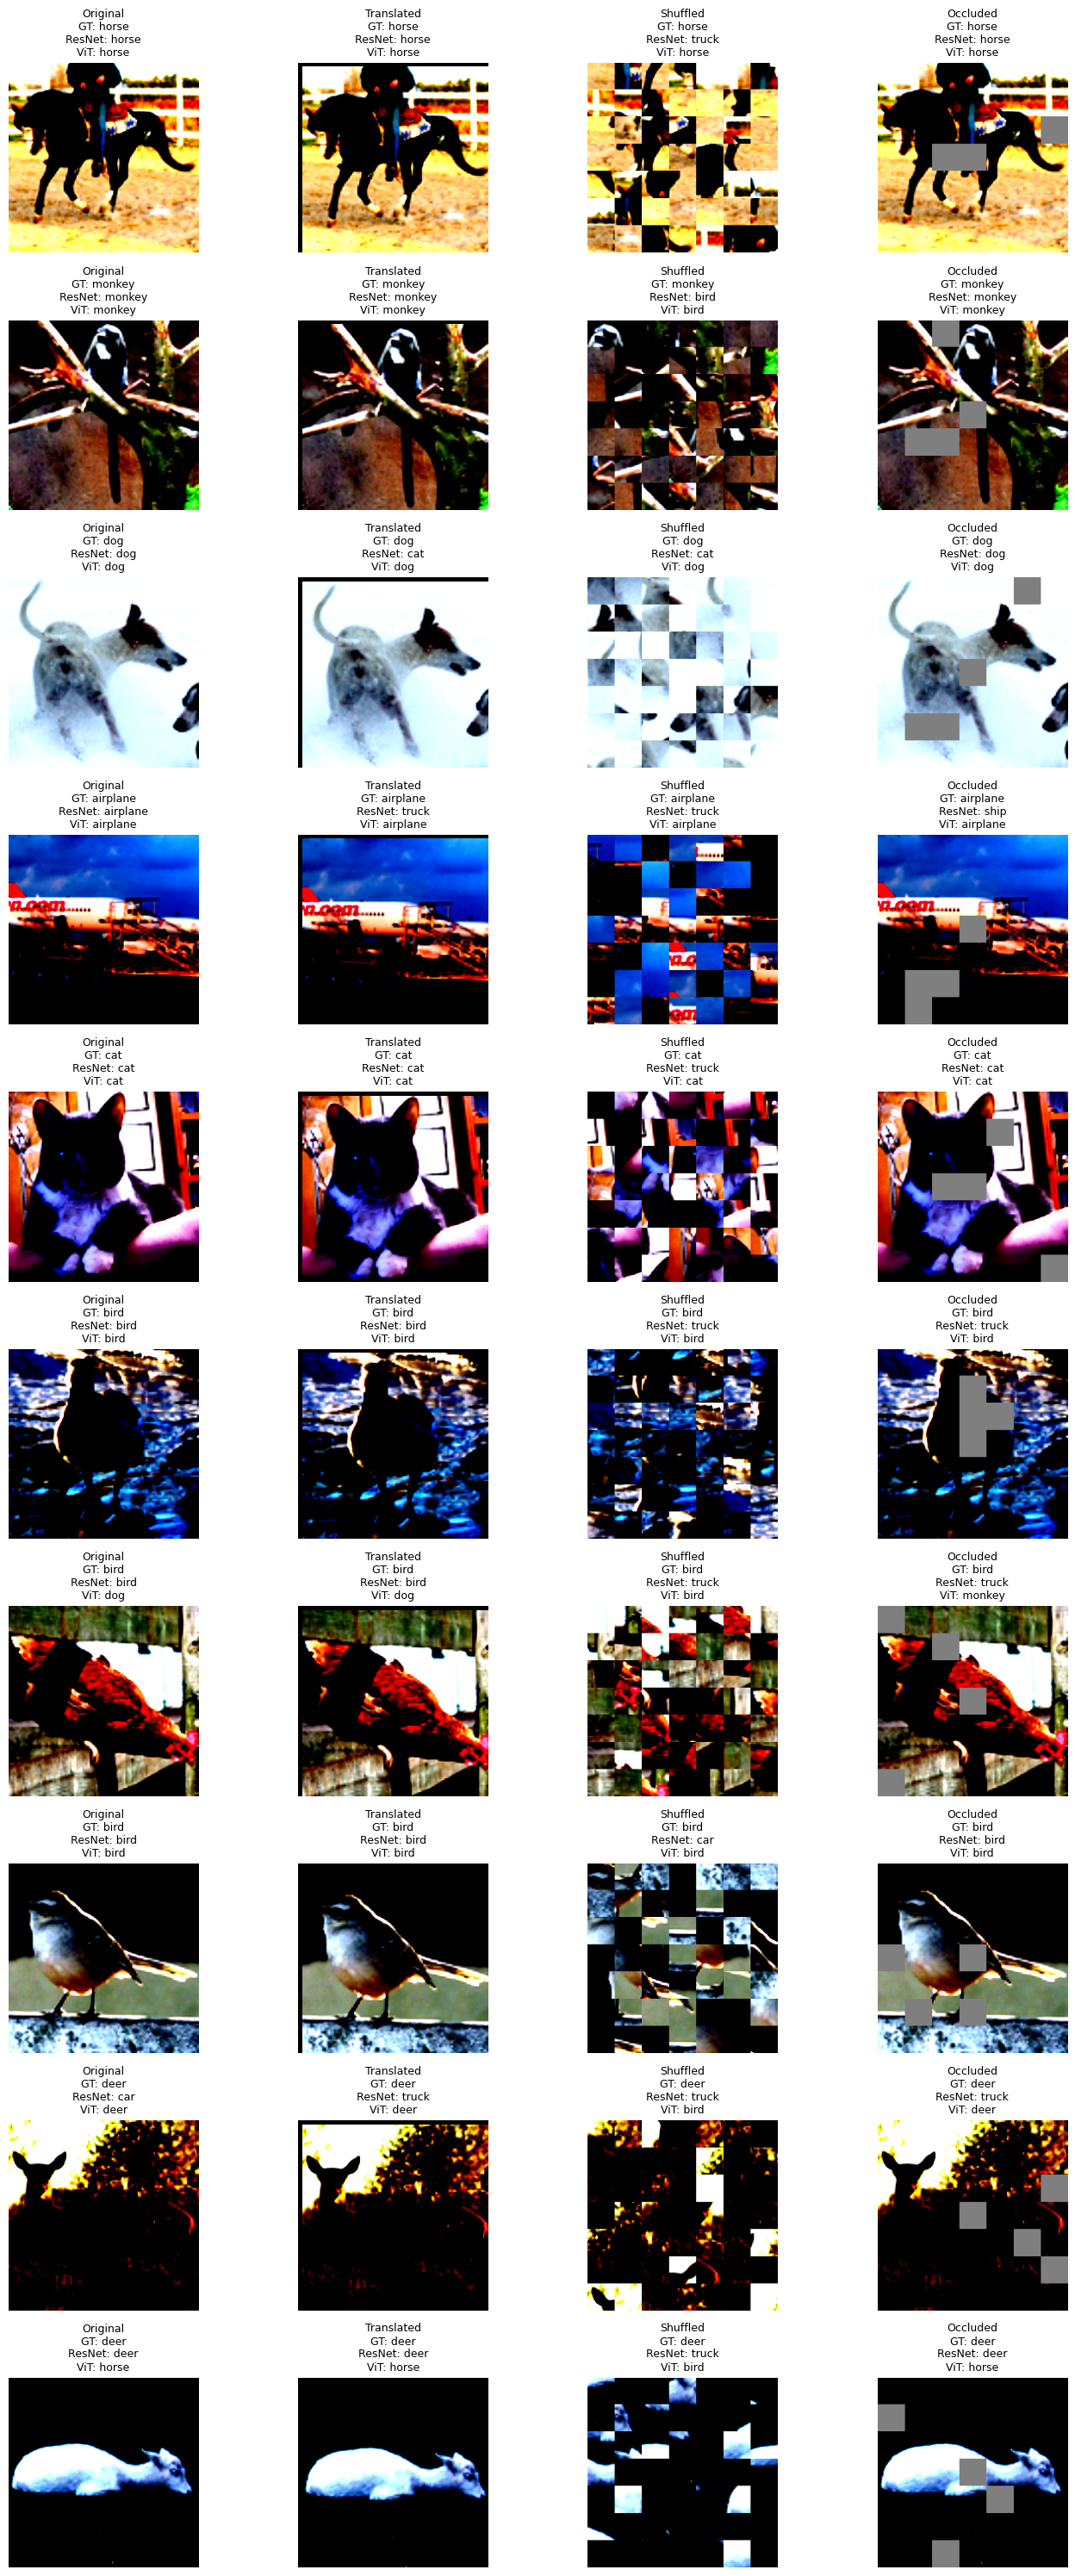

In [24]:
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch

def get_prediction(model, img, class_names, device):
    model.eval()
    with torch.no_grad():
        img = img.unsqueeze(0).to(device)
        output = model(img)
        pred = output.argmax(dim=1).item()
    return class_names[pred]

def visualize_examples(resnet, vit, test_loader, class_names, device, n=5):
    imgs, labels = next(iter(test_loader))
    imgs, labels = imgs[:n], labels[:n]

    fig, axes = plt.subplots(n, 4, figsize=(14, 3*n))

    for i in range(n):
        orig = imgs[i].cpu()
        label = class_names[labels[i]]

        translated = translate_image(orig, dx=5, dy=5)
        shuffled = patch_shuffle(orig, patch_size=32)
        occluded = patch_occlusion(orig.clone(), patch_size=32)  

        variants = [("Original", orig),
                    ("Translated", translated),
                    ("Shuffled", shuffled),
                    ("Occluded", occluded)]

        for j, (title, variant) in enumerate(variants):
            ax = axes[i, j] if n > 1 else axes[j]
            img_np = variant.permute(1, 2, 0).cpu().numpy()

            resnet_pred = get_prediction(resnet, variant, class_names, device)
            vit_pred = get_prediction(vit, variant, class_names, device)

            ax.imshow(img_np)
            ax.axis("off")
            ax.set_title(f"{title}\nGT: {label}\nResNet: {resnet_pred}\nViT: {vit_pred}",
                         fontsize=9)

    plt.tight_layout()
    plt.show()

visualize_examples(resnet, vit, test_loader, test_loader.dataset.classes, device, n=10)
